In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.util as model_util
import model.mechint_net as mechint_net
import model.cnn as cnn
import model.explainn as explainn
import feature.util as feature_util
import feature.experimental_dataset as experimental_dataset
import train.train_model as train_model
import plot.plot_motifs as plot_motifs
import analysis.motif_util as motif_util
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pyfaidx
import tqdm.notebook
import sklearn.metrics

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [5]:
mechint_model_path = os.path.join(base_path, "models/trained_models/experimental/dnase_gm12878/mechint_net/1/last_ckpt.pth")
cnn_model_path = os.path.join(base_path, "models/trained_models/experimental/dnase_gm12878/standard_cnn/1/last_ckpt.pth")
explainn_model_path = os.path.join(base_path, "models/trained_models/experimental/dnase_gm12878/explainn/2/last_ckpt.pth")

In [6]:
peak_bed_path = os.path.join(base_path, "data/encode/dnase/ENCSR000EMT_GM12878/ENCFF073ORT_peaks.bed.gz")

In [7]:
qtls_table_path = os.path.join(base_path, "data/databases/LCL.dsQTL.hg38.tsv")
genome_fasta_path = os.path.join(base_path, "data/genomes/hg38.fa")

In [8]:
chrom_set = ["chr1"]
# chrom_set = ["chr" + str(i) for i in range(1, 24)] + ["chrX"]

In [9]:
input_len = 500

In [10]:
figures_out_path = "/home/tsenga5/mechint_regnet/figures/qtl_analysis"
os.makedirs(figures_out_path, exist_ok=True)

### Import models

In [11]:
mechint_model = model_util.load_model(
    mechint_net.MechIntRegNet, mechint_model_path
).to(DEVICE)

cnn_model = model_util.load_model(
    cnn.ConvNet, cnn_model_path
).to(DEVICE)

explainn_model = model_util.load_model(
    explainn.ExplaiNN, explainn_model_path
).to(DEVICE)

### Import QTLs

In [12]:
qtl_table = pd.read_csv(qtls_table_path, sep="\t", header=0, index_col=False)

In [13]:
# Limit to specified chromosomes
qtl_table = qtl_table[qtl_table["chrom_hg38"].isin(chrom_set)]

# Show label counts
print("Label\tCount")
for key, count in zip(*np.unique(qtl_table["label"], return_counts=True)):
    print(key, "\t", count)

Label	Count
-1 	 2318
1 	 48


### Test QTL predictions

In [14]:
genome_reader = pyfaidx.Fasta(genome_fasta_path, "r")

In [15]:
def make_qtl_predictions(model, qtl_table, genome_reader, seq_len, batch_size=32):
    """
    For a given model and table of QTLs, makes predictions for each allele.
    Returns two arrays of prediction values parallel to the QTL table: for
    allele 1 and allele 2.
    """
    allele_1_preds, allele_2_preds = [], []
    num_batches = int(np.ceil(len(qtl_table) / batch_size))
    for batch_i in tqdm.notebook.trange(num_batches):
        batch_start = batch_i * batch_size
        batch_end = batch_start + batch_size
        
        # Get batch of QTLs
        subtable = qtl_table.iloc[batch_start : batch_end]

        # Get allele sequences for QTLs
        allele_1_seqs, allele_2_seqs = [], []
        for _, row in subtable.iterrows():
            # Get genomic sequence
            chrom, allele_pos = row["chrom_hg38"], row["pos_hg38"]
            allele_rel_pos = (seq_len // 2) - 1
            seq_start = allele_pos - allele_rel_pos - 1
            seq_end = seq_start + seq_len
            seq = genome_reader[chrom][seq_start : seq_end].seq.upper()

            # Substitute in both alleles
            seq_left = seq[:allele_rel_pos]
            seq_right = seq[allele_rel_pos + 1:]
            allele_1, allele_2 = row["allele1"], row["allele2"]
            if seq[allele_rel_pos] not in (allele_1, allele_2):
                print("Warning: no alleles matched to reference sequence: %s:%d %s->%s" % (chrom, allele_pos, allele_1, allele_2))
            
            allele_1_seqs.append(seq_left + allele_1 + seq_right)
            allele_2_seqs.append(seq_left + allele_2 + seq_right)

        # Convert allele sequences to one-hot encodings
        allele_1_one_hots = feature_util.seqs_to_one_hot(allele_1_seqs)
        allele_2_one_hots = feature_util.seqs_to_one_hot(allele_2_seqs)
            
        # Make predictions from model
        allele_1_preds.append(model(torch.tensor(allele_1_one_hots).to(DEVICE).float())[:, 0].detach().cpu().numpy())
        allele_2_preds.append(model(torch.tensor(allele_2_one_hots).to(DEVICE).float())[:, 0].detach().cpu().numpy())

    return np.concatenate(allele_1_preds), np.concatenate(allele_2_preds)

In [16]:
# Run QTL predictions for each allele
mechint_preds_a1, mechint_preds_a2 = make_qtl_predictions(mechint_model, qtl_table, genome_reader, input_len)
cnn_preds_a1, cnn_preds_a2 = make_qtl_predictions(cnn_model, qtl_table, genome_reader, input_len)
explainn_preds_a1, explainn_preds_a2 = make_qtl_predictions(explainn_model, qtl_table, genome_reader, input_len)

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

In [17]:
# Compute predicted QTL effect sizes by taking absolute difference
mechint_effects = np.abs(mechint_preds_a1 - mechint_preds_a2)
cnn_effects = np.abs(cnn_preds_a1 - cnn_preds_a2)
explainn_effects = np.abs(explainn_preds_a1 - explainn_preds_a2)

In [18]:
labels = qtl_table["label"].values
labels[labels == -1] = 0  # Convert -1 to 0

In [19]:
mechint_prec = sklearn.metrics.average_precision_score(labels, mechint_effects)
mechint_auroc = sklearn.metrics.roc_auc_score(labels, mechint_effects)
cnn_prec = sklearn.metrics.average_precision_score(labels, cnn_effects)
cnn_auroc = sklearn.metrics.roc_auc_score(labels, cnn_effects)
explainn_prec = sklearn.metrics.average_precision_score(labels, explainn_effects)
explainn_auroc = sklearn.metrics.roc_auc_score(labels, explainn_effects)

print("ARGMINN")
print("AP: %.4f" % mechint_prec)
print("auROC: %.4f" % mechint_auroc)
print()
print("Traditional CNN")
print("AP: %.4f" % cnn_prec)
print("auROC: %.4f" % cnn_auroc)
print()
print("ExplaiNN")
print("AP: %.4f" % explainn_prec)
print("auROC: %.4f" % explainn_auroc)

ARGMINN
AP: 0.1409
auROC: 0.7513

Traditional CNN
AP: 0.0824
auROC: 0.6996

ExplaiNN
AP: 0.0995
auROC: 0.6531


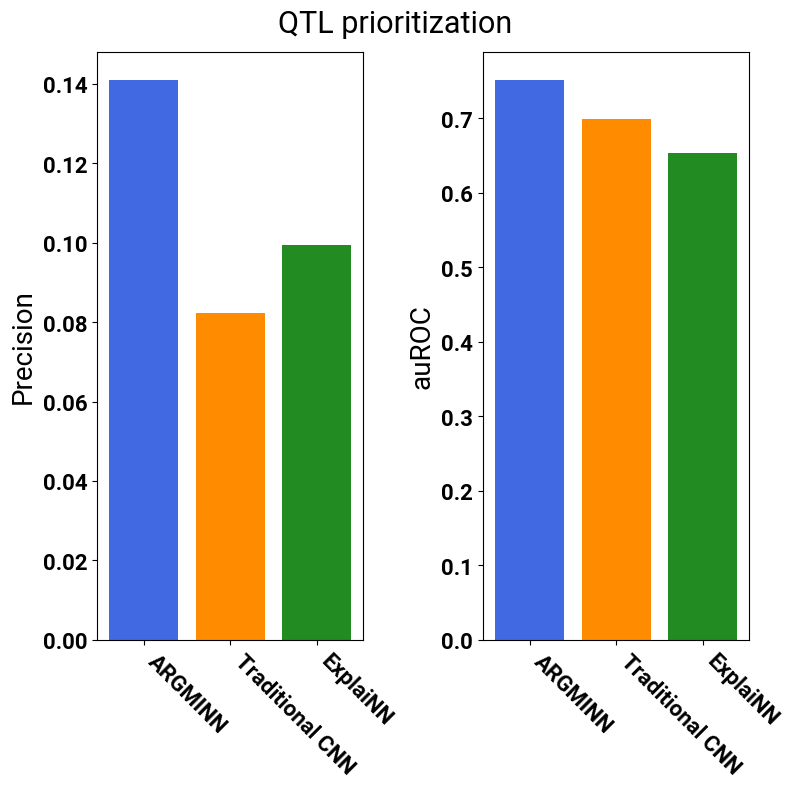

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 8))
x = np.arange(3)
labels = ["ARGMINN", "Traditional CNN", "ExplaiNN"]
colors = ["royalblue", "darkorange", "forestgreen"]
ax[0].bar(x, [mechint_prec, cnn_prec, explainn_prec], color=colors)
ax[0].set_ylabel("Precision")
ax[1].bar(x, [mechint_auroc, cnn_auroc, explainn_auroc], color=colors)
ax[1].set_ylabel("auROC")
for i in range(2):
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels, rotation=-45, ha="left")
fig.suptitle("QTL prioritization")
fig.tight_layout()
fig.savefig(os.path.join(figures_out_path, "prec_auroc_bar.svg"), format="svg")
plt.show()

### View QTLs in ARGMINN

In [21]:
def model_to_pfms(model, data_loader, max_thresh_frac=0.5):
    """
    Given a model and a data loader, runs through the input sequences
    in the data loader and collects convolutional activations from the
    entire epoch.
    Returns a F x W x 4 array of PFMs for the filters. If a filter is
    never activated, its PFM will be all 0.
    """
    _, _, _, _, model_outputs_other, input_data = \
        train_model.run_epoch(data_loader, "eval", model, epoch_num=0, return_extras=True)
    conv_acts = model_outputs_other["conv_acts"]  # Shape: N x L' x F
    input_seqs = input_data[0]  # Shape: N x L x 4
    num_filters = conv_acts.shape[2]
    filter_width = input_seqs.shape[1] - conv_acts.shape[1] + 1

    # Compute minimum activations needed
    act_threshes = np.max(conv_acts, axis=(0, 1)) * max_thresh_frac

    # Construct PFMs
    pfms = np.zeros((num_filters, filter_width, 4))
    for i in range(num_filters):
        if act_threshes[i] == 0:
            continue
        ex_inds, start_inds = np.where(conv_acts[:, :, i] > act_threshes[i])
        if not ex_inds.size:
            # Nothing passed the threshold
            continue
        # Trick to get all matching subsequences, where we flatten the set of all
        # indices we want and then reshape
        seqs = input_seqs[
            np.repeat(ex_inds, filter_width),
            (np.arange(filter_width)[None] + start_inds[:, None]).reshape(-1)
        ].reshape(len(ex_inds), filter_width, -1)
        pfms[i] = np.mean(seqs, axis=0)

    return pfms

In [22]:
data_loader = experimental_dataset.dataset_ex.run(
    "create_data_loader", config_updates={
        "peaks_bed_path": peak_bed_path,
        "batch_size": 128,
        "chrom_set": (["chr" + str(i) for i in range(1, 24)] + ["chrX"]),  # Entire dataset
        "negative_ratio": 0  # No negatives
    }
).result

WARNING - root - Added new config entry: "chrom_set"
WARNING - root - Added new config entry: "peaks_bed_path"
WARNING - exp_dataset - No observers have been added to this run
INFO - exp_dataset - Running command 'create_data_loader'
INFO - exp_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - exp_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x154da818aa80>
INFO - exp_dataset - Completed after 0:00:00


In [23]:
pfms = model_to_pfms(mechint_model, data_loader)

	Loss: 0.8567: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [00:25<00:00, 47.97it/s]


/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3

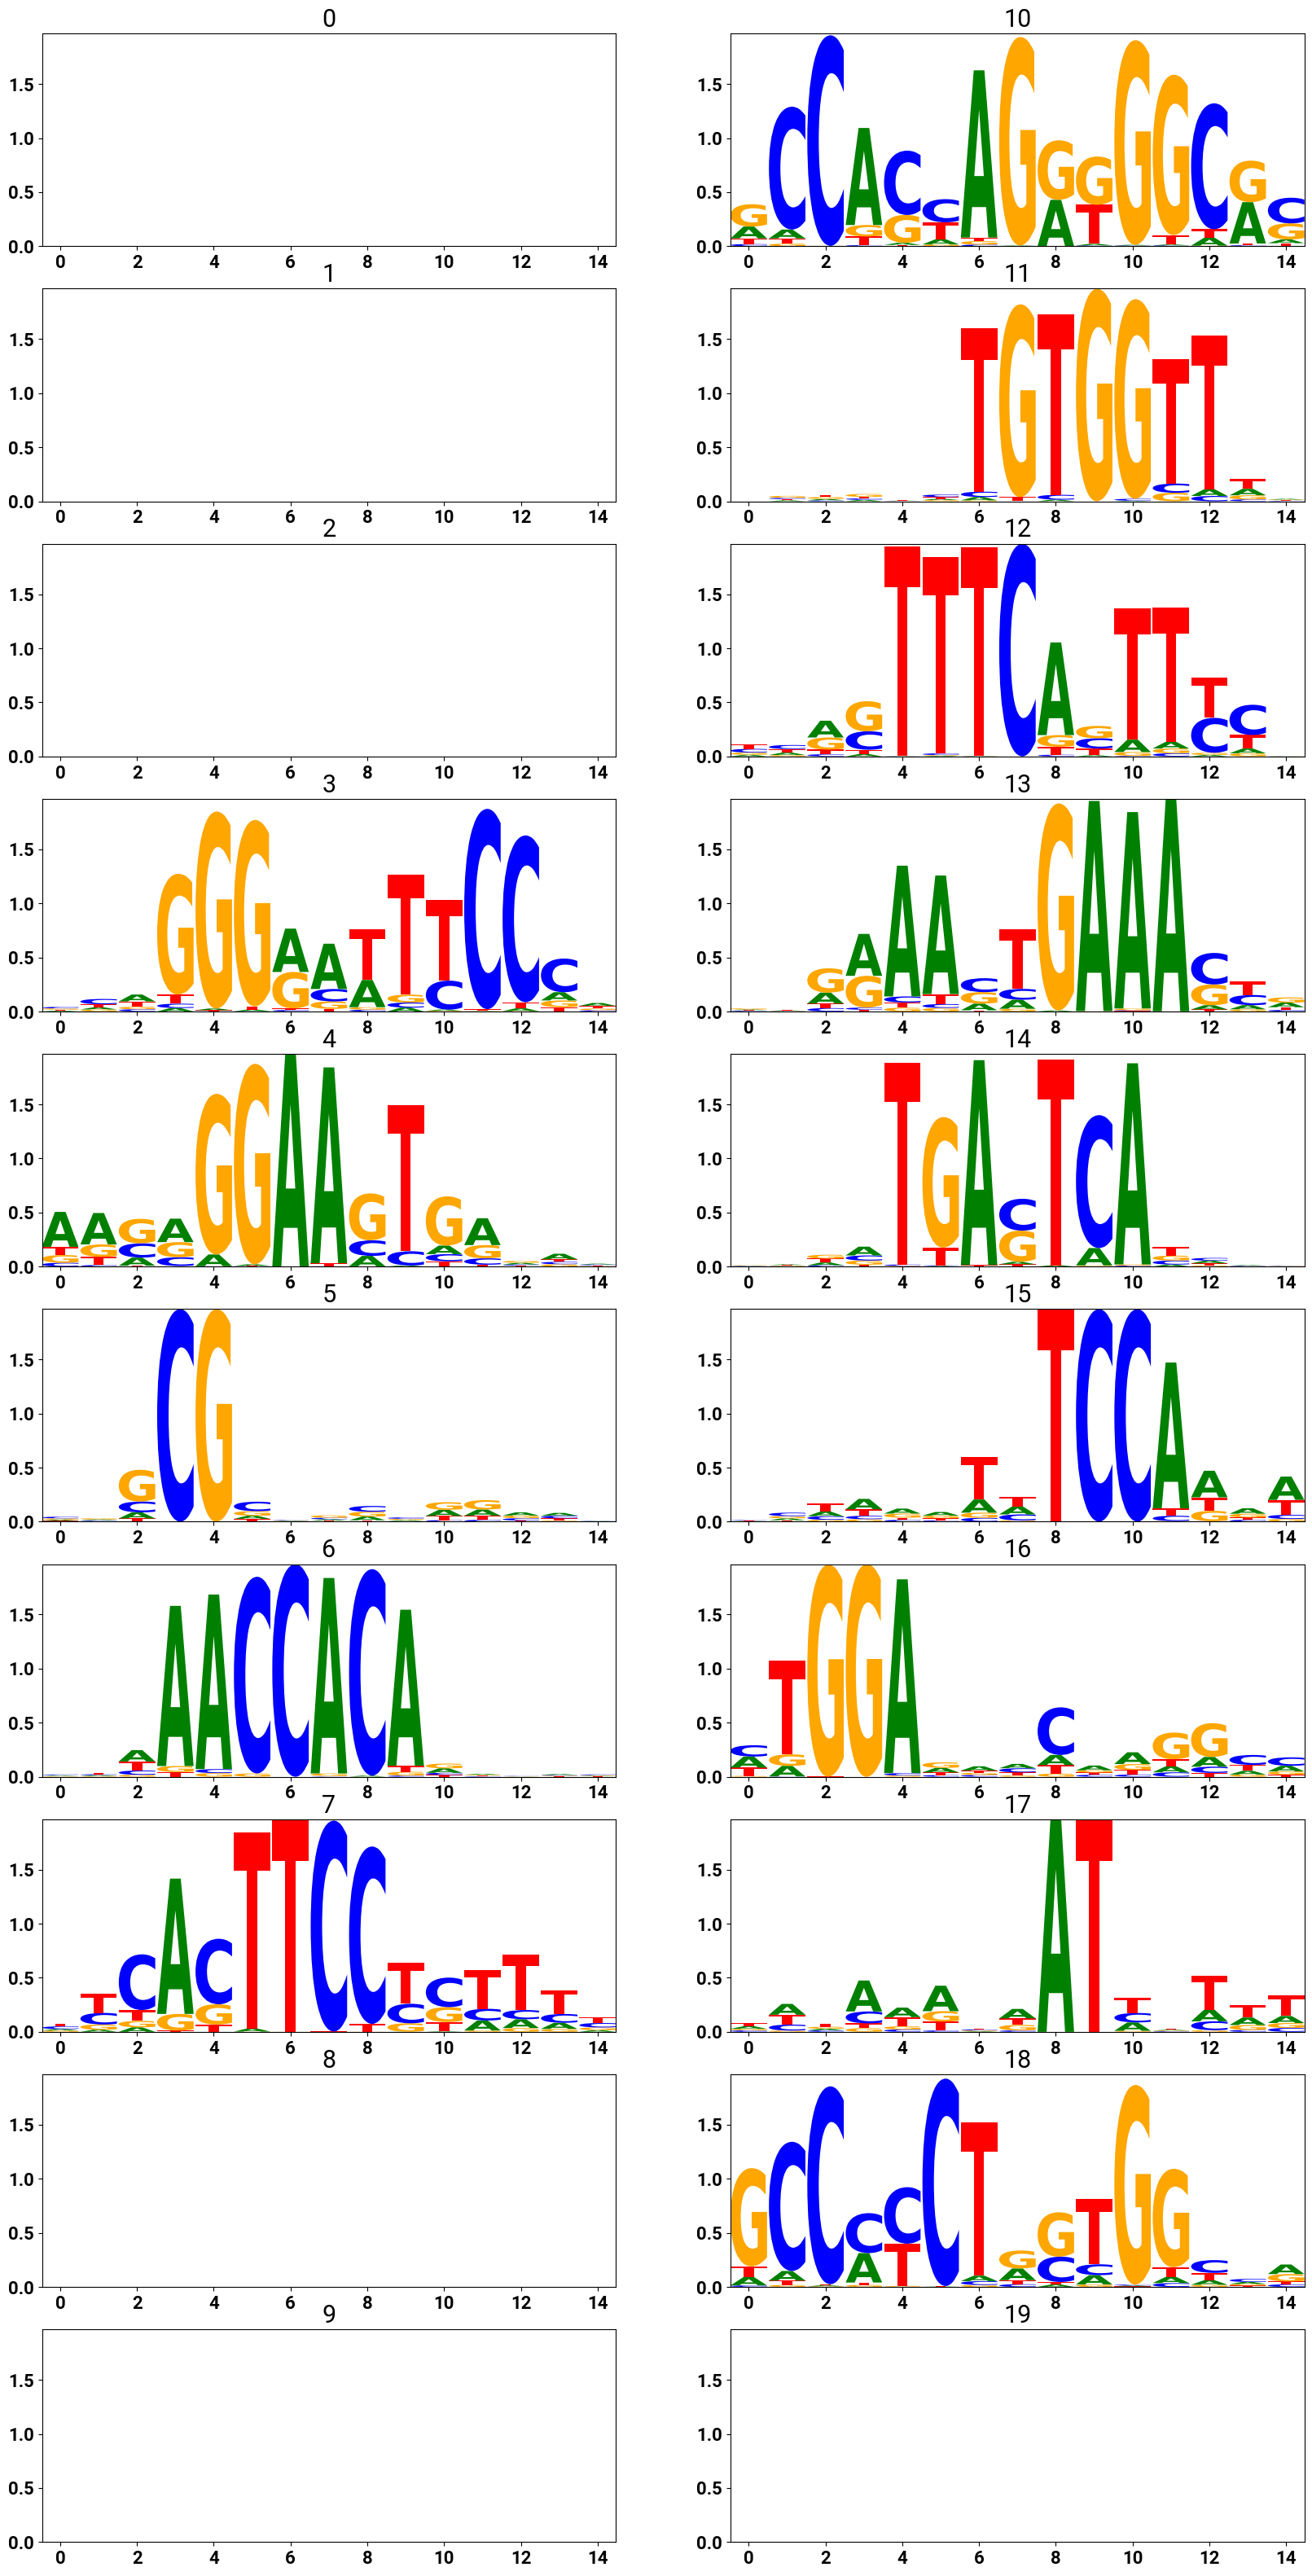

In [24]:
plot_motifs.plot_motif_grid(
    [pfm * motif_util.pfm_info_content(pfm)[:, None] for pfm in pfms],
    titles=[str(i) for i in range(len(pfms))]
)
plt.show()

In [25]:
# Get indices of QTLs which are in the positive set and had the highest effect sizes
top_k = 20
mechint_effects_copy = mechint_effects.copy()
mechint_effects_copy[labels == 0] = -1  # Effect sizes are all non-negative so -1 is lower
top_qtl_inds = np.flip(np.argsort(mechint_effects_copy))[:top_k]

QTL 25 - chr1:89085986, C vs G
0.0307 vs 0.6827


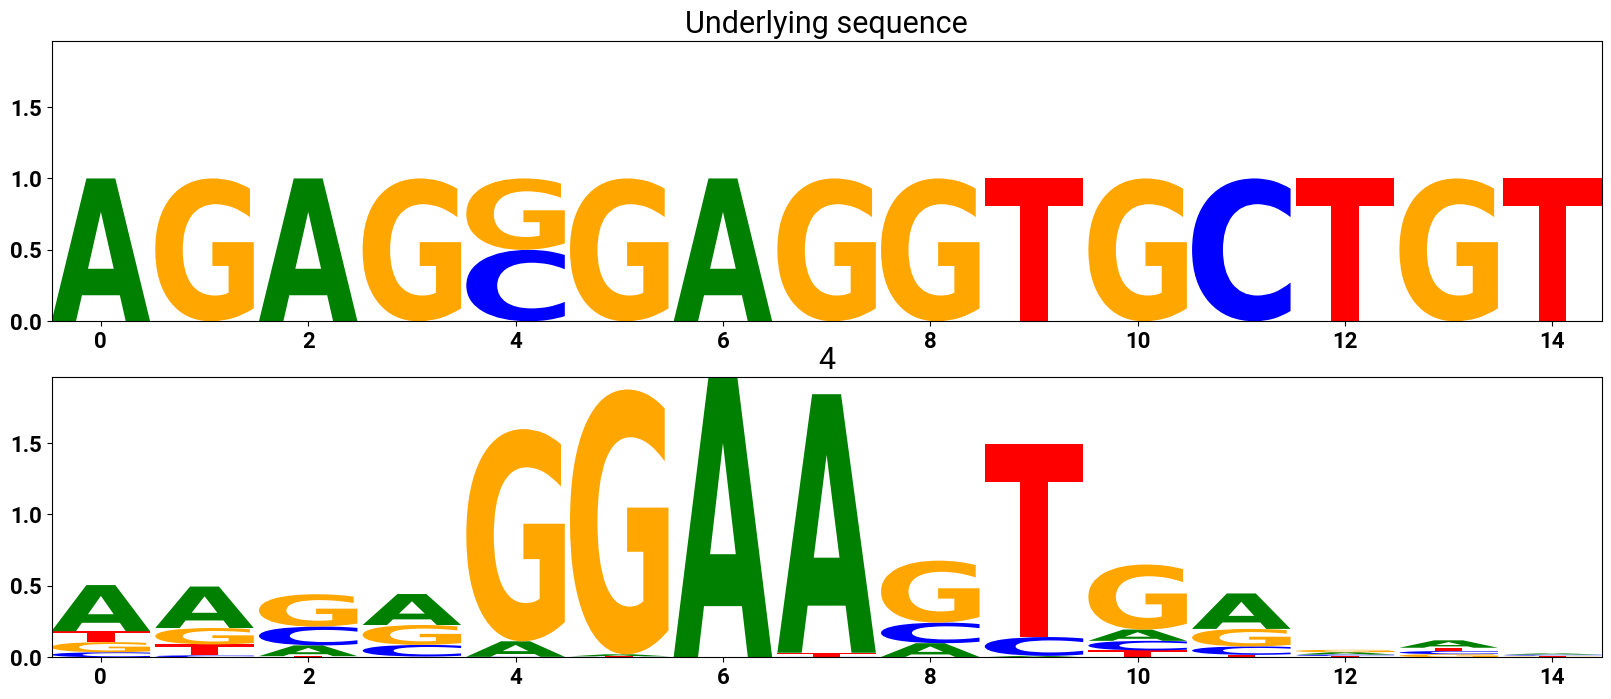


QTL 41 - chr1:207997972, T vs C
0.3875 vs 0.7213


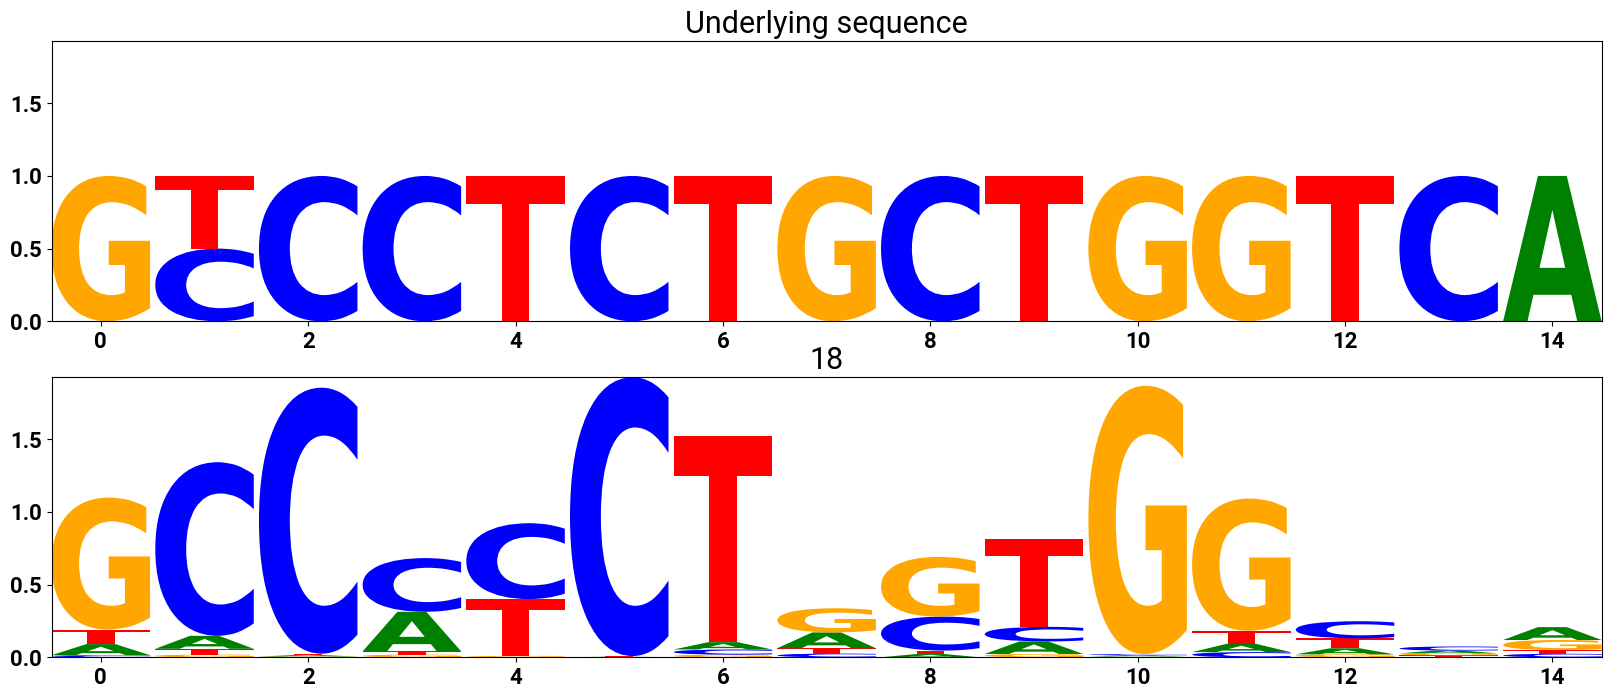


No high attention scores found for QTL 26
QTL 1543 - chr1:87317622, A vs G
0.0769 vs 0.3544


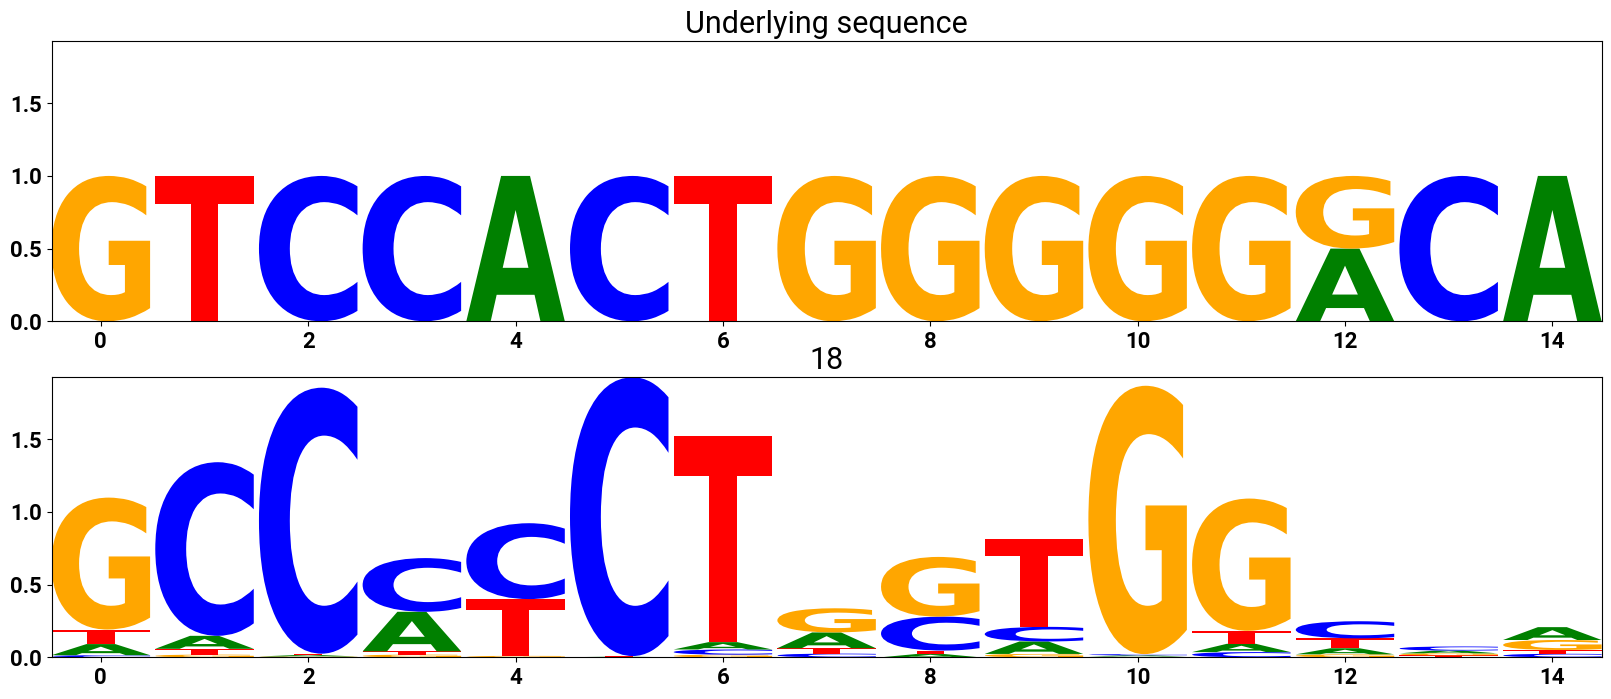


QTL 1302 - chr1:42784224, A vs G
0.3296 vs 0.5460


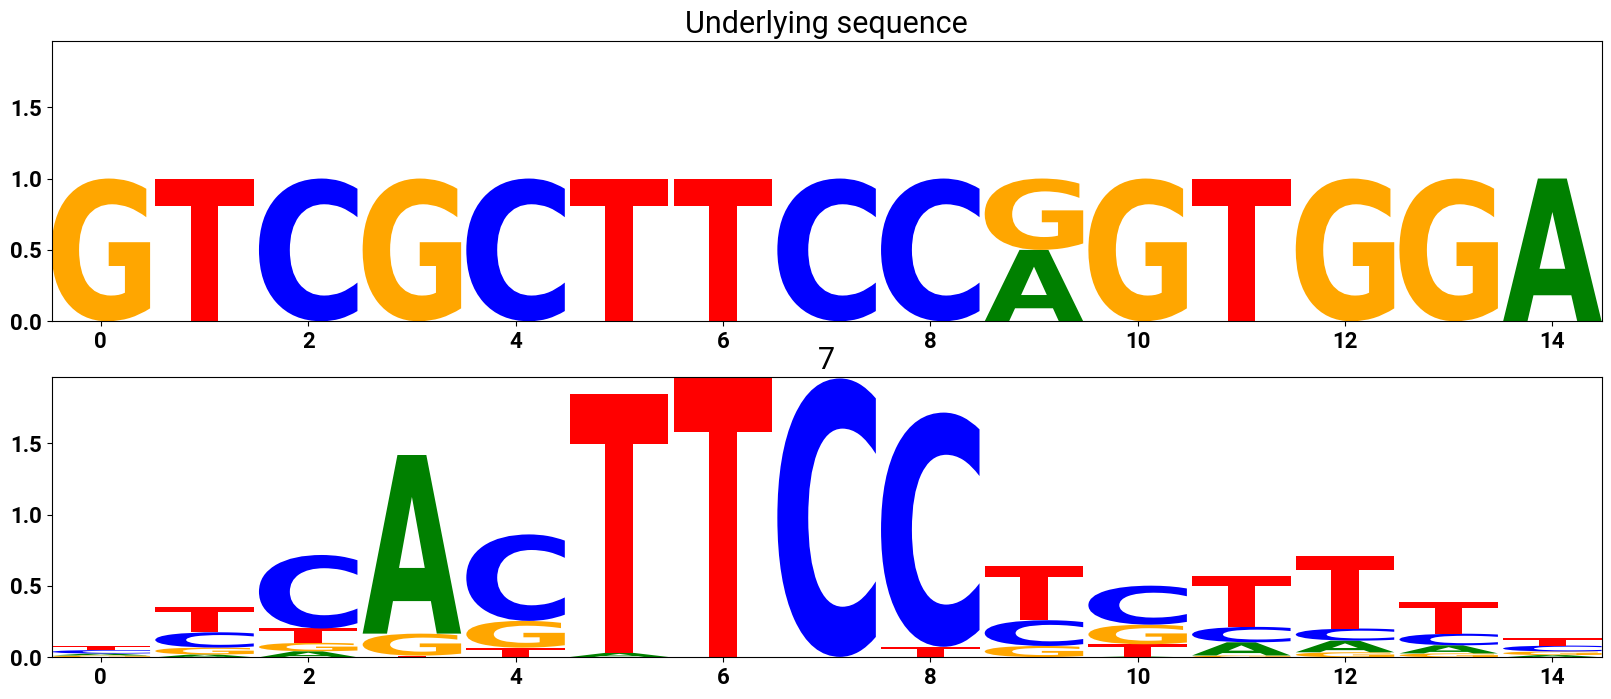


QTL 1127 - chr1:31199596, C vs G
0.4299 vs 0.6180


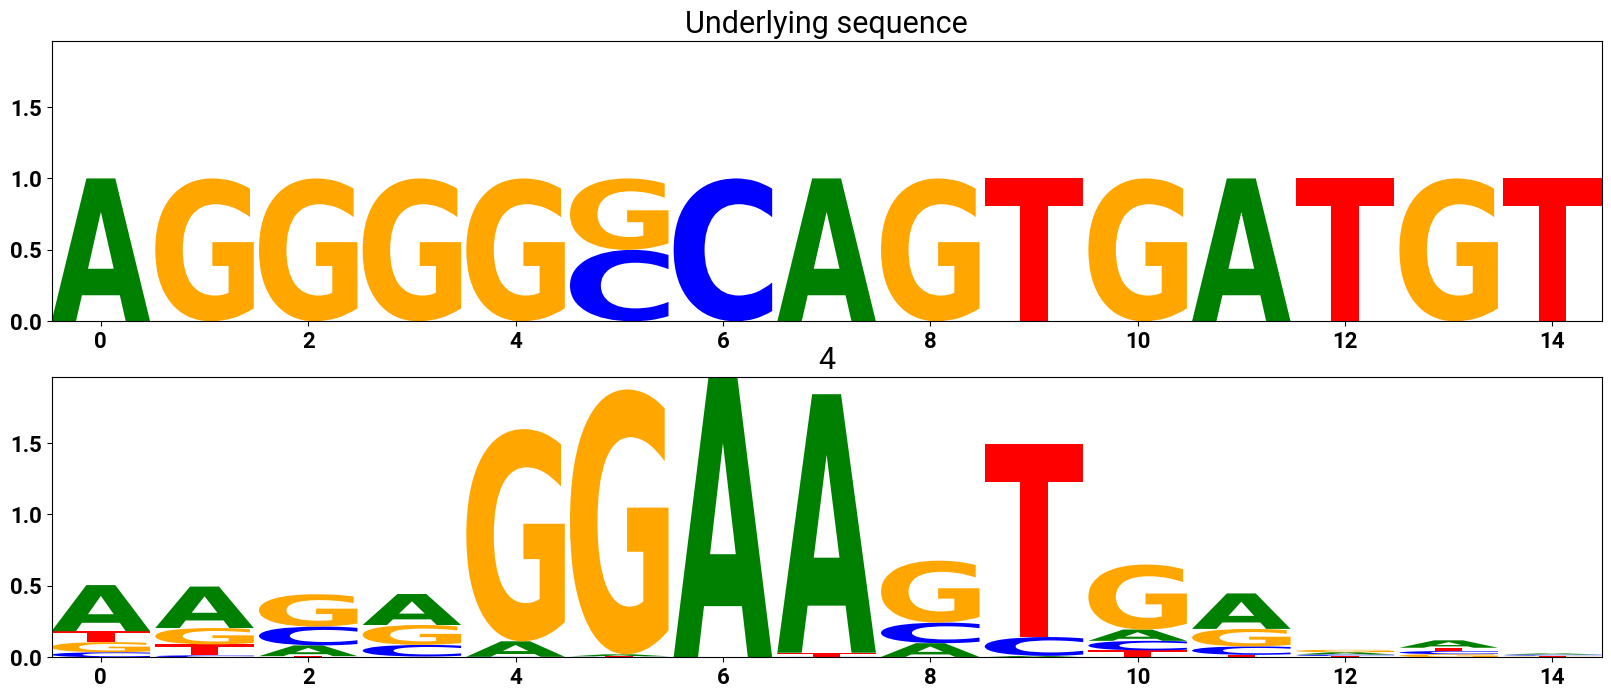


No high attention scores found for QTL 237
QTL 958 - chr1:24169298, T vs G
0.6251 vs 0.4407


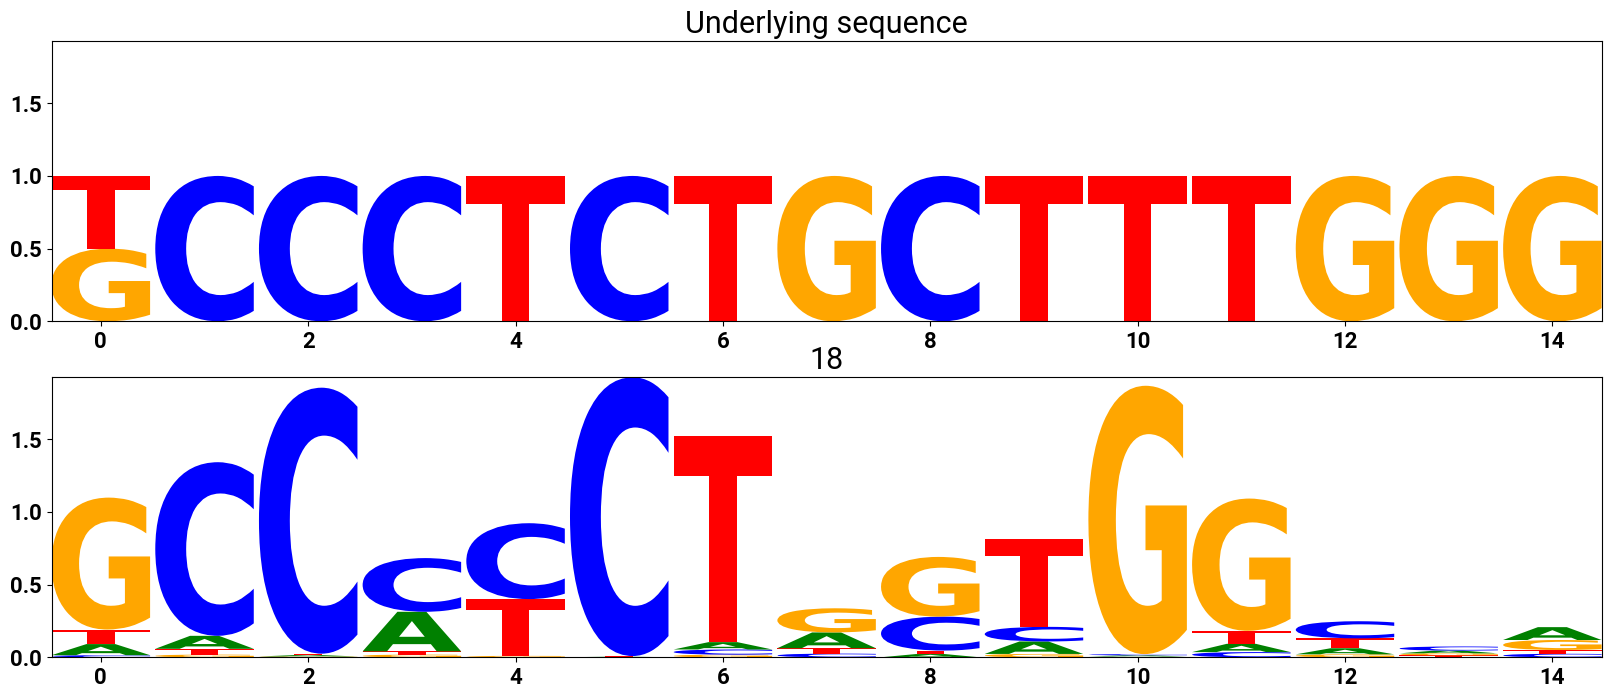


QTL 1978 - chr1:201512622, G vs A
0.7373 vs 0.5586


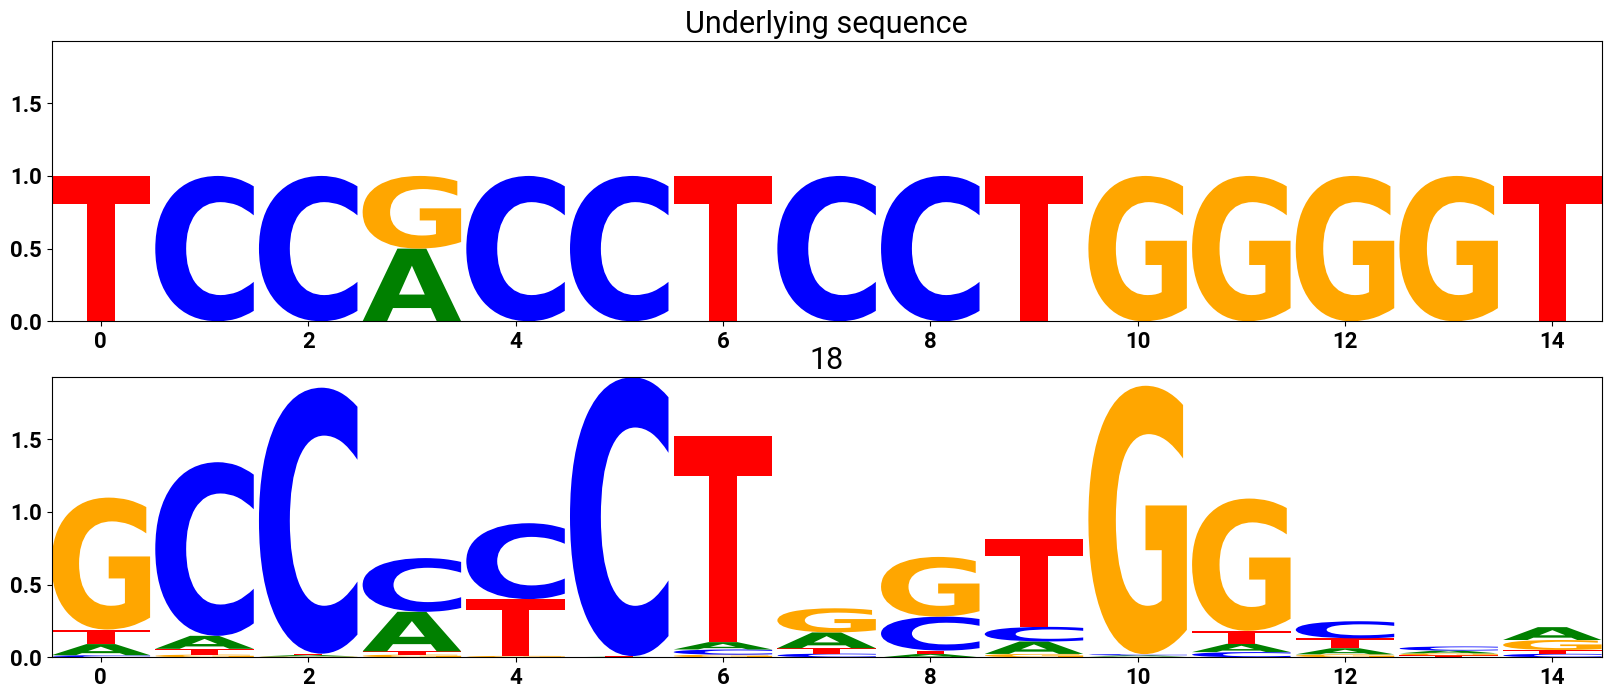

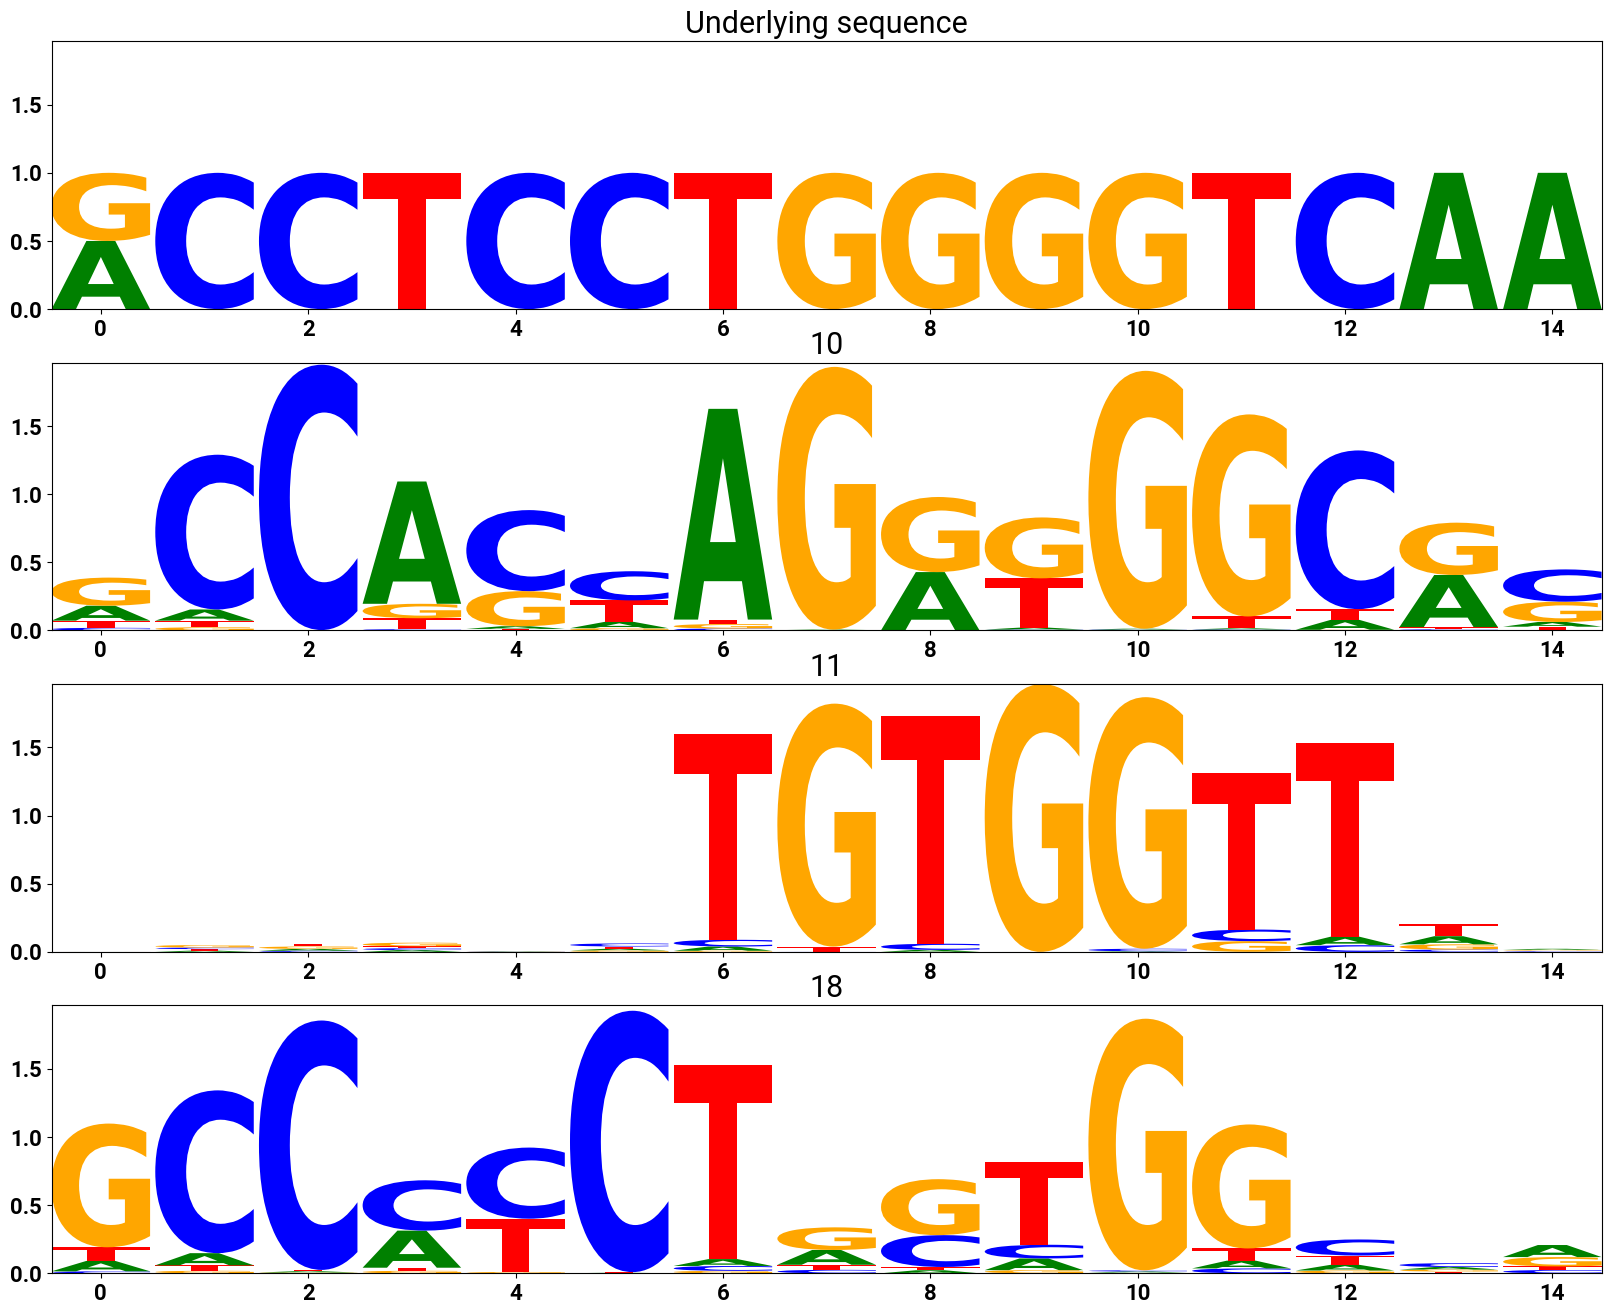


No high attention scores found for QTL 2126
QTL 1420 - chr1:53123270, G vs A
0.5255 vs 0.6936


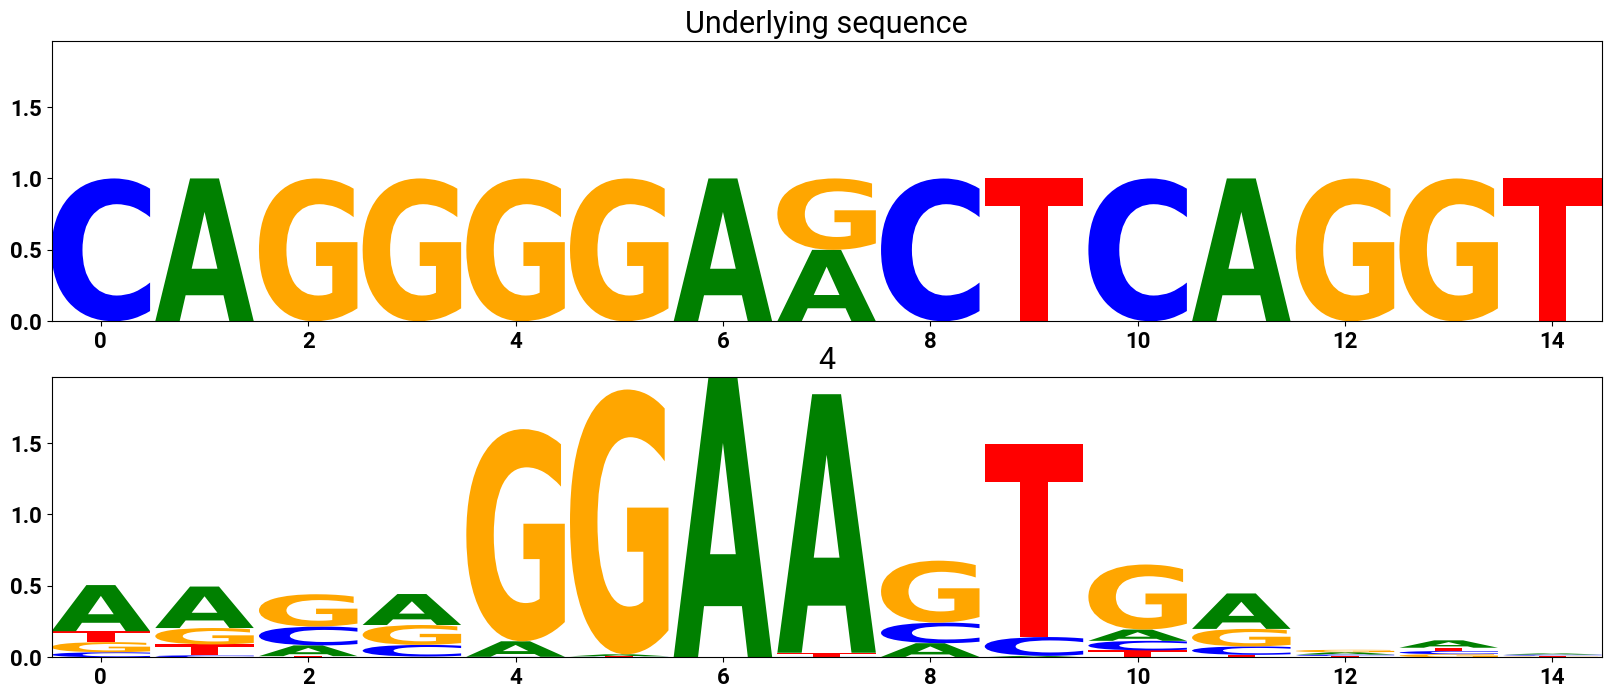


No high attention scores found for QTL 2280
QTL 2201 - chr1:226733072, A vs G
0.6455 vs 0.5109


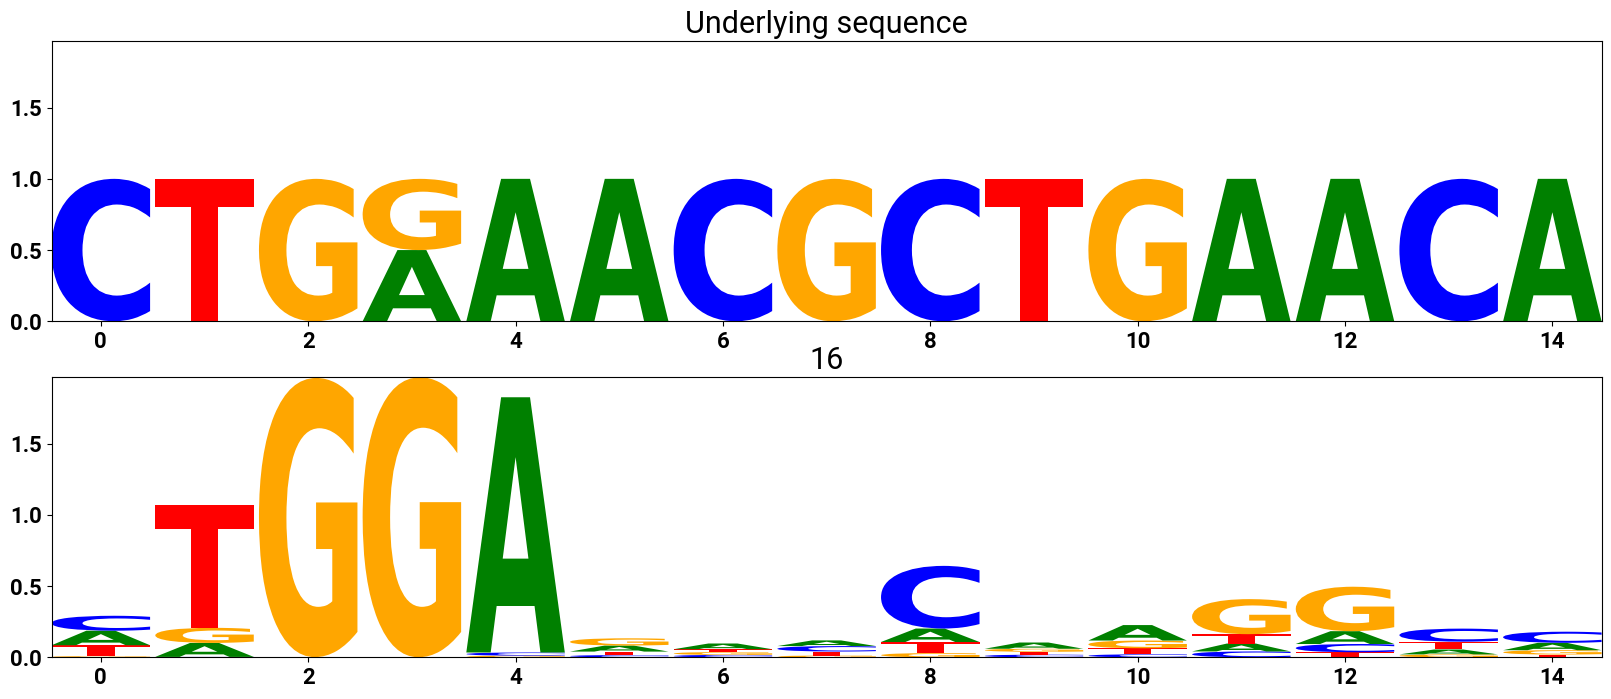


No high attention scores found for QTL 1092
No high attention scores found for QTL 10
No high attention scores found for QTL 842
No high attention scores found for QTL 665
QTL 869 - chr1:21334891, A vs G
0.4982 vs 0.6266


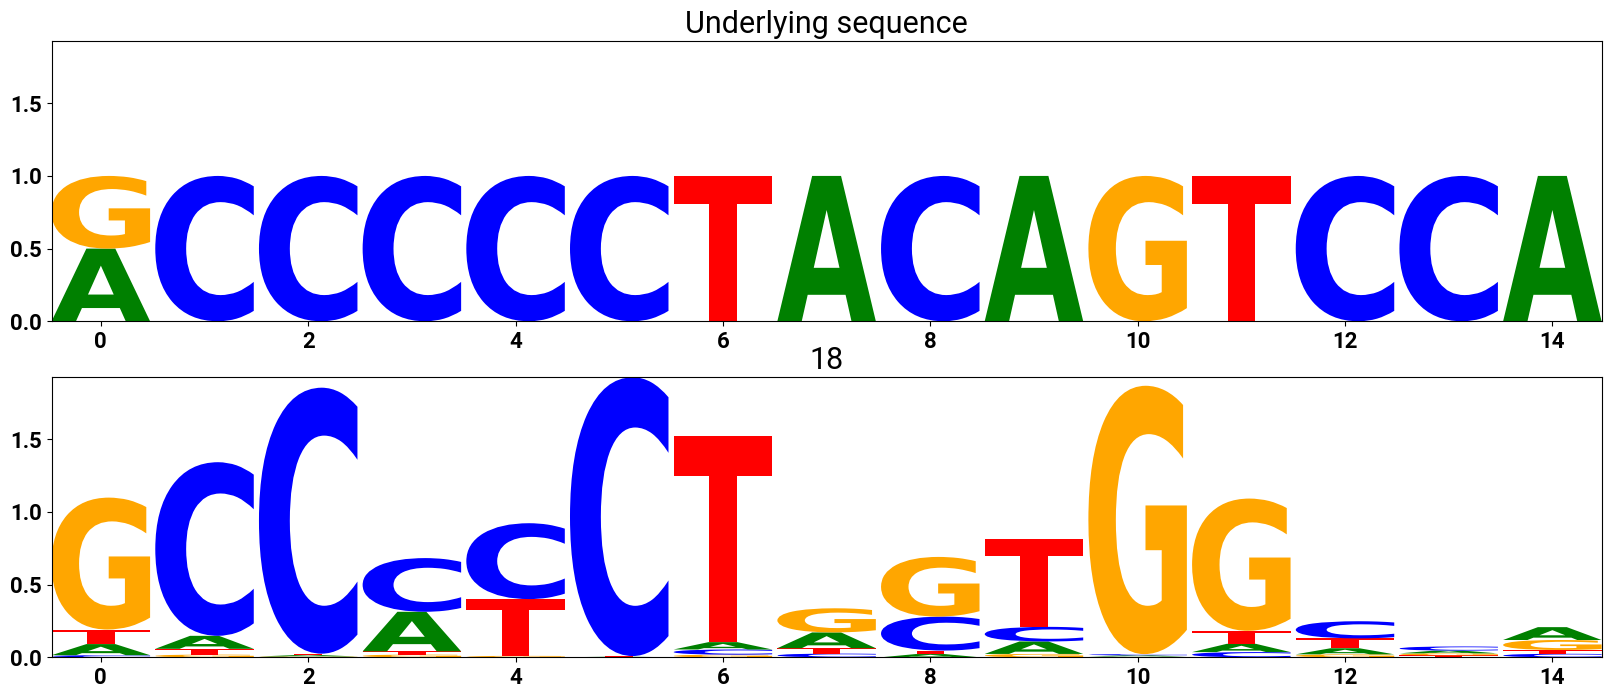


No high attention scores found for QTL 788
QTL 1058 - chr1:28306667, A vs G
0.6650 vs 0.5415


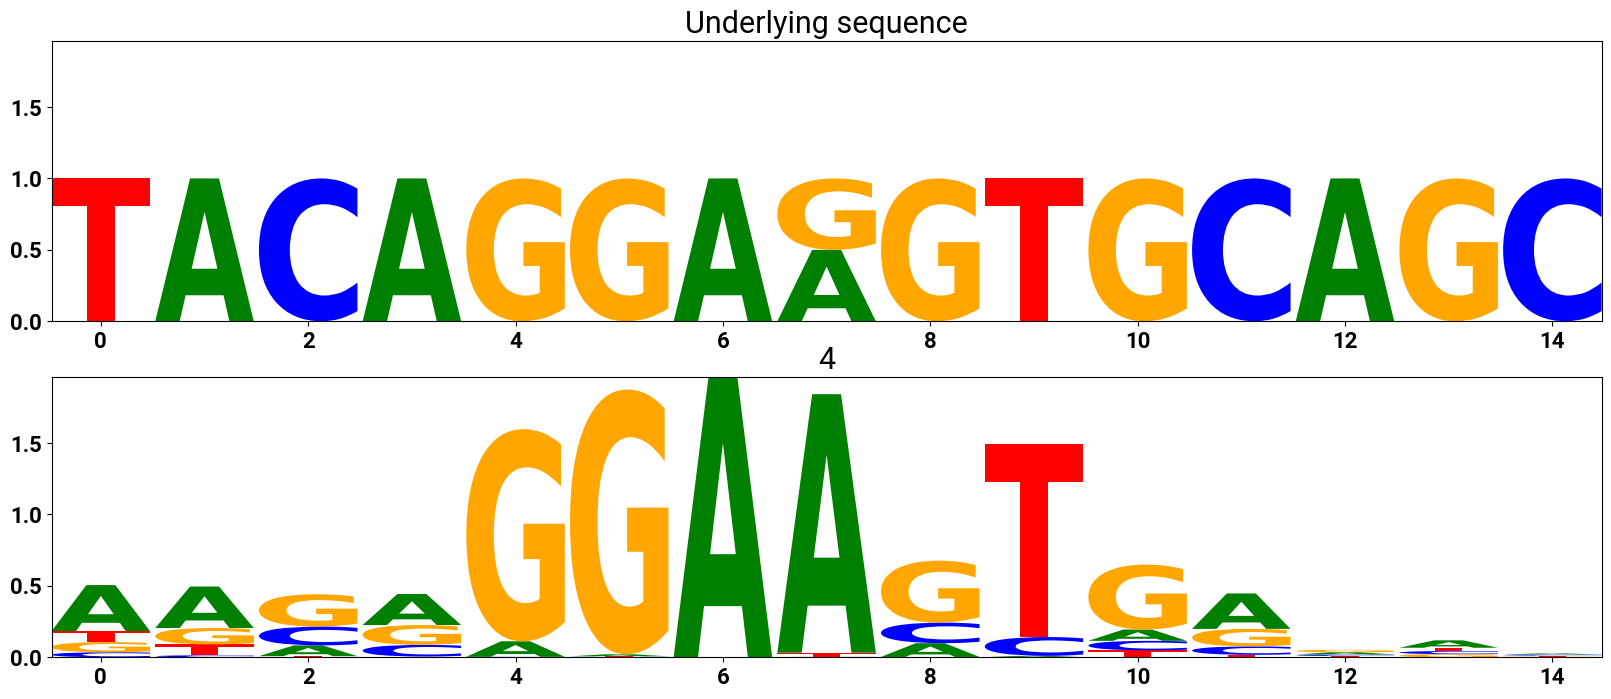

In [26]:
# For each top QTL, run predictions in ARGMINN and fetch the attention scores/filters for the allele
for qtl_i in top_qtl_inds:
    row = qtl_table.iloc[qtl_i]

    # Get genomic sequence
    chrom, allele_pos = row["chrom_hg38"], row["pos_hg38"]
    allele_rel_pos = (input_len // 2) - 1
    seq_start = allele_pos - allele_rel_pos - 1
    seq_end = seq_start + input_len
    seq = genome_reader[chrom][seq_start : seq_end].seq.upper()

    # Substitute in both alleles
    seq_left = seq[:allele_rel_pos]
    seq_right = seq[allele_rel_pos + 1:]
    allele_1, allele_2 = row["allele1"], row["allele2"]
    allele_1_seq = seq_left + allele_1 + seq_right
    allele_2_seq = seq_left + allele_2 + seq_right
    seqs = [allele_1_seq, allele_2_seq]
    
    # Convert allele sequences to one-hot encodings
    one_hots = feature_util.seqs_to_one_hot(seqs)
        
    # Make predictions from model
    preds, interims = mechint_model(torch.tensor(one_hots).to(DEVICE).float(), return_interims=True)
    preds = preds[:, 0].detach().cpu().numpy()
    conv_acts = interims["conv_acts"].detach().cpu().numpy()  # Shape: B x L' x F
    att_vals = interims["att_vals"].detach().cpu().numpy()  # Shape: B x AL x AH x L'
    att_vals_allele_max = np.max(att_vals, axis=(1, 2))  # Max over layers/heads; Shape: B x L'

    # Get any positions in the sequence which had a high attention score (either example)
    high_att_score_inds = np.where(np.max(att_vals_allele_max, axis=0) > 0.9)[0]

    # Filter for positions where a filter would overlap with the allelic position
    filter_width = input_len - conv_acts.shape[1] + 1
    high_att_score_inds = high_att_score_inds[
        (high_att_score_inds >= (allele_rel_pos - filter_width + 1)) &
        (high_att_score_inds <= allele_rel_pos)
    ]
    if not high_att_score_inds.size:
        print("No high attention scores found for QTL %d" % qtl_i)
        continue

    print("QTL %d - %s:%d, %s vs %s" % (qtl_i, chrom, allele_pos, allele_1, allele_2))
    print("%.4f vs %.4f" % (mechint_preds_a1[qtl_i], mechint_preds_a2[qtl_i]))

    # For each position of high attention score:
    for seq_pos in high_att_score_inds:
        # Get the set of activating filter (either sequence)
        filter_inds = np.where(np.max(conv_acts[:, seq_pos], axis=0) > 0)[0]

        # Compute the position within the motif the allele corresponds to
        filter_pos = allele_rel_pos - seq_pos        

        # Extract the underlying sequence underneath these filters
        subseqs = [s[seq_pos : seq_pos + filter_width] for s in seqs]

        # Plot underlying sequence and activating filters
        to_plot = [np.mean(feature_util.seqs_to_one_hot(subseqs), axis=0)]
        to_plot.extend([
            pfms[i] * motif_util.pfm_info_content(pfms[i])[:, None] for i in filter_inds
        ])
        titles = ["Underlying sequence"] + [str(i) for i in filter_inds]
        fig = plot_motifs.plot_motif_grid(to_plot, titles=titles, num_cols=1)
        fig.savefig(os.path.join(figures_out_path, "qtl_ex_%d.svg" % qtl_i), format="svg")
        plt.show()

    print()